In [2]:
# Importing Libraries 
import numpy as np
import tensorflow as tf
from keras.models import Sequential,Model
from keras import applications
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from mtcnn import MTCNN
from PIL import Image
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import load_model
import numpy as np
import time
import cv2
import os
import cvlib as cv
from PIL import Image, ImageFont, ImageDraw

In [3]:
data = pd.read_csv(r"../data/data.csv")
data.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


In [4]:
data[data['bmi'] == data['bmi'].max()]

,Unnamed: 0,bmi,gender,is_training,name
4180,4180,85.987061,Female,0,img_4180.bmp


In [5]:
data_new = data.drop(["Unnamed: 0","gender","is_training"],axis=1)
data_new.head()

,bmi,name
0,34.207396,img_0.bmp
1,26.453720,img_1.bmp
2,34.967561,img_2.bmp
3,22.044766,img_3.bmp
4,37.758789,img_4.bmp


<Axes: ylabel='Frequency'>

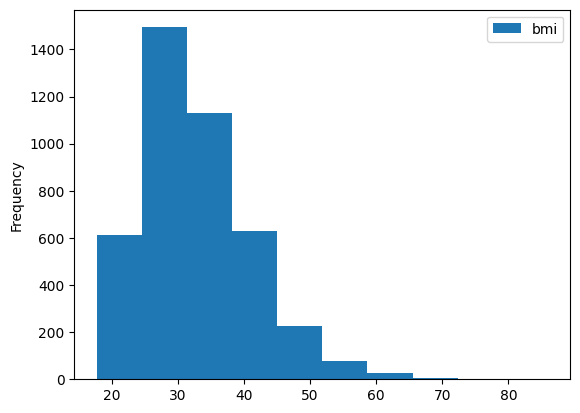

In [6]:
data_new.plot(kind="hist")

In [63]:
image_size = 100
batch_size=32
extracted_path = r"../data/extracted_faces/"
images_path = r"../data/Images/"
epochs = 100

In [8]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    h = image.shape[0]
    w = image.shape[1]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    # return the resized image
    return resized

In [37]:
detector = MTCNN()

def extract_face(filename,size = 100):
    image = cv2.imread(filename)
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)
    if results == []:
        return "No Face"
    else:
        x1, y1, width, height = results[0]['box']
        x1 = max(0,x1-50)
        y1 = max(0,y1-50)
        x2= min(x1 + width + 50,pixels.shape[1])
        y2 =  min(y1 + height + 50,pixels.shape[0])
        face = pixels[y1:y2, x1:x2]
        h = face.shape[0]
        w = face.shape[1]
        new_image = np.zeros((size,size,3))
        if w>h:
            image = image_resize(face,width=size)
            height_offset = int((new_image.shape[0] - image.shape[0])/2)
            new_image[height_offset:int(image.shape[0]+height_offset), :image.shape[1]] = image
        elif h>w:
            image = image_resize(face,height=size)
            width_offset = int((new_image.shape[1] - image.shape[1])/2)
            new_image[:image.shape[0], width_offset:int(image.shape[1] + width_offset)] = image
        else:
            image = image_resize(face,width=size,height=size)
            new_image[:image.shape[0], :image.shape[1]] = image
        # image = image.resize(required_size)
        # face_array = np.asarray(image)
        return new_image

In [10]:
# if not os.path.exists(extracted_path):
#     os.mkdir(extracted_path)
# for subdir,dir,filenames in os.walk(images_path):
#     for filename in filenames:
#         if ".bmp" in filename:
#             print("Processing : " + filename)
#             filepath = images_path+filename    
#             pixels = extract_face(filepath)
#             if pixels!= "No Face":
#                 cv2.imwrite(extracted_path+filename,pixels)

In [11]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=data_new, directory=images_path, x_col="name", y_col="bmi",has_ext=True, class_mode="other", target_size=image_size, batch_size=batch_size,subset="training")
val_generator = datagen.flow_from_dataframe(dataframe=data_new, directory=images_path, x_col="name", y_col="bmi",has_ext=True, class_mode="other", target_size=image_size, batch_size=batch_size,subset="validation")

Found 3170 validated image filenames.
Found 792 validated image filenames.


c:\Users\yomaa\Documents\Environments\tensorflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 244 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  warnings.warn(
c:\Users\yomaa\Documents\Environments\tensorflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 244 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  warnings.warn(


In [64]:
fat_guy_location = r"C:\Users\yomaa\OneDrive\Pictures\bmi_500.jpg"

#preprocess the image
fat_guy = extract_face(fat_guy_location,size=image_size)
fat_guy = fat_guy/255
fat_guy = fat_guy.reshape(1,image_size,image_size,3)

1/1 [==============================] - 0s 14ms/step


In [65]:
thin_guy_location = r"C:\Users\yomaa\OneDrive\Pictures\bmi_200.jpg"

#preprocess the image
thin_guy = extract_face(thin_guy_location,size=image_size)
thin_guy = thin_guy/255
thin_guy = thin_guy.reshape(1,image_size,image_size,3)

1/1 [==============================] - 0s 12ms/step


In [15]:
def create_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(kernel_size=(3,3), filters=128, activation='relu', input_shape=image_size + (3,))) # 198,198,32
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu')) 
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=256,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=256,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=256,kernel_size = (3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=256,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=512,kernel_size = (3,3),activation='relu'))
    model.add(AveragePooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dense(units=1,activation='relu'))
    model.compile(
                loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                optimizer='adam'
                )
    return model
classifier = create_model()
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 98, 98, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 49, 49, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 47, 47, 128)       147584    
                                                                 
 conv2d_47 (Conv2D)          (None, 45, 45, 128)       147584    
                                                                 
 conv2d_48 (Conv2D)          (None, 43, 43, 128)      

In [16]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_new.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
output = classifier.fit(train_generator,validation_data=val_generator,epochs=epochs,callbacks=[model_checkpoint])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 131.4389 - rmse: 11.4647
Epoch 1: val_rmse improved from inf to 10.59140, saving model to best_model_new.h5
100/100 [==============================] - 49s 457ms/step - loss: 131.4389 - rmse: 11.4647 - val_loss: 112.1778 - val_rmse: 10.5914
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 100.7789 - rmse: 10.0389
Epoch 2: val_rmse improved from 10.59140 to 9.80328, saving model to best_model_new.h5
100/100 [==============================] - 5s 46ms/step - loss: 101.2789 - rmse: 10.0637 - val_loss: 96.1043 - val_rmse: 9.8033
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 106.6517 - rmse: 10.3272
Epoch 3: val_rmse improved from 9.80328 to 8.71822, saving model to best_model_new.h5
100/100 [==============================] - 5s 46ms/step - loss: 106.6517 - rmse: 10.3272 - val_loss: 76.0074 - val_rmse: 8.7182
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 8

In [40]:
classifier = tf.keras.models.load_model("best_model_new.h5")
classifier.predict(thin_guy)

1/1 [==============================] - 0s 85ms/step


array([[32.156483]], dtype=float32)

In [41]:
classifier = tf.keras.models.load_model("best_model_new.h5")
classifier.predict(fat_guy)

1/1 [==============================] - 0s 82ms/step


array([[33.154507]], dtype=float32)

In [25]:
vgg_model = VGGFace(include_top=False, input_shape=(100, 100, 3))

In [26]:
vgg_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 100, 100, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 100, 100, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 50, 50, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 50, 50, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 128)     

In [27]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [28]:
def vgg_model_basic(models):
    x = Conv2D(kernel_size=(3,3), filters=128, activation='relu')(models.layers[-1].output) # 198,198,32
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(units=64,activation='relu')(x)
    regressor = Dense(units=1,activation='relu')(x)
    model_final = Model(models.input,regressor)
    model_final.compile(
                loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                optimizer='adam'
                )
    return model_final
vgg_model_basic = vgg_model_basic(vgg_model)
vgg_model_basic.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 100, 100, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 100, 100, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 50, 50, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 50, 50, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 128)       0   

In [29]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg_basic_new.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
output = vgg_model_basic.fit(train_generator,validation_data=val_generator,epochs=100,callbacks=[model_checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 514.9073 - rmse: 22.6916
Epoch 1: val_rmse improved from inf to 31.49486, saving model to best_model_vgg_basic_new.h5
100/100 [==============================] - 9s 74ms/step - loss: 514.9073 - rmse: 22.6916 - val_loss: 991.9261 - val_rmse: 31.4949
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 100.4602 - rmse: 10.0230
Epoch 2: val_rmse improved from 31.49486 to 11.17295, saving model to best_model_vgg_basic_new.h5
100/100 [==============================] - 3s 34ms/step - loss: 99.8393 - rmse: 9.9920 - val_loss: 124.8347 - val_rmse: 11.1729
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 67.0790 - rmse: 8.1902
Epoch 3: val_rmse improved from 11.17295 to 8.48883, saving model to best_model_vgg_basic_new.h5
100/100 [==============================] - 3s 33ms/step - loss: 67.3444 - rmse: 8.2064 - val_loss: 72.0602 - val_rmse: 8.4888
Epoch 4/100
 98/100 [=====================

In [42]:
vgg_model_basic = tf.keras.models.load_model("best_model_vgg_basic_new.h5")
vgg_model_basic.predict(fat_guy)

1/1 [==============================] - 0s 88ms/step


array([[31.515465]], dtype=float32)

In [43]:
vgg_model_basic = tf.keras.models.load_model("best_model_vgg_basic_new.h5")
vgg_model_basic.predict(thin_guy)

1/1 [==============================] - 0s 91ms/step


array([[29.800467]], dtype=float32)

In [44]:
def vgg_dense(models):
    x = models.output
    x = Flatten()(x)
    x = Dense(units = 64,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=32,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=8,activation='relu')(x)
    regressor = Dense(units=1,activation='relu')(x)
    model_final = Model(models.input,regressor)
    model_final.compile(
                loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                optimizer='adam'
                )
    return model_final
vgg_dense_regressor = vgg_dense(vgg_model)
vgg_dense_regressor.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 100, 100, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 100, 100, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 50, 50, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 50, 50, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 128)       0  

In [45]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg_dense_new.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
output = vgg_dense_regressor.fit(train_generator,validation_data=val_generator,epochs=100,callbacks=[model_checkpoint])

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 618.1538 - rmse: 24.8627
Epoch 1: val_rmse improved from inf to 14.68988, saving model to best_model_vgg_dense_new.h5
100/100 [==============================] - 6s 49ms/step - loss: 613.6080 - rmse: 24.7711 - val_loss: 215.7926 - val_rmse: 14.6899
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 139.4758 - rmse: 11.8100
Epoch 2: val_rmse improved from 14.68988 to 13.30477, saving model to best_model_vgg_dense_new.h5
100/100 [==============================] - 5s 50ms/step - loss: 139.4758 - rmse: 11.8100 - val_loss: 177.0170 - val_rmse: 13.3048
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 94.6584 - rmse: 9.7293
Epoch 3: val_rmse did not improve from 13.30477
100/100 [==============================] - 5s 48ms/step - loss: 94.8427 - rmse: 9.7387 - val_loss: 202.3366 - val_rmse: 14.2245
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 80.8387 - rmse: 

In [46]:
vgg_dense_regressor = tf.keras.models.load_model("best_model_vgg_dense_new.h5")
vgg_dense_regressor.predict(fat_guy)

1/1 [==============================] - 0s 88ms/step


array([[16.882088]], dtype=float32)

In [47]:
vgg_dense_regressor = tf.keras.models.load_model("best_model_vgg_dense_new.h5")
vgg_dense_regressor.predict(thin_guy)

1/1 [==============================] - 0s 90ms/step


array([[15.983465]], dtype=float32)

In [60]:
def vgg_complex(models):
    x = models.output
    x = Conv2D(kernel_size=(3,3), filters=128, activation='relu', input_shape=image_size + (3,))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(units=32,activation='relu')(x)
    x = Dense(units=16,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=8,activation='relu')(x)
    x = Dropout(0.3)(x)
    regressor = Dense(units=1,activation='linear')(x)
    model_final = Model(models.input,regressor)
    model_final.compile(
                loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                optimizer='adam'
                )
    return model_final
vgg_complex_regressor = vgg_complex(vgg_model)
vgg_complex_regressor.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 100, 100, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 100, 100, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 50, 50, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 50, 50, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 128)       0  

In [61]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg_complex_100.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
output = vgg_complex_regressor.fit(train_generator,validation_data=val_generator,epochs=100,callbacks=[model_checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 572.4147 - rmse: 23.9252
Epoch 1: val_rmse improved from inf to 15.44361, saving model to best_model_vgg_complex_100.h5
100/100 [==============================] - 6s 52ms/step - loss: 572.4147 - rmse: 23.9252 - val_loss: 238.5050 - val_rmse: 15.4436
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 220.0852 - rmse: 14.8353
Epoch 2: val_rmse improved from 15.44361 to 12.60228, saving model to best_model_vgg_complex_100.h5
100/100 [==============================] - 6s 56ms/step - loss: 220.0307 - rmse: 14.8334 - val_loss: 158.8174 - val_rmse: 12.6023
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 179.7376 - rmse: 13.4066
Epoch 3: val_rmse improved from 12.60228 to 12.50834, saving model to best_model_vgg_complex_100.h5
100/100 [==============================] - 5s 47ms/step - loss: 179.7376 - rmse: 13.4066 - val_loss: 156.4585 - val_rmse: 12.5083
Epoch 4/100
 99/100 [======

In [66]:
vgg_complex_regressor = tf.keras.models.load_model("best_model_vgg_complex_100.h5")
vgg_complex_regressor.predict(fat_guy)

1/1 [==============================] - 0s 101ms/step


array([[29.444458]], dtype=float32)

In [67]:
vgg_complex_regressor = tf.keras.models.load_model("best_model_vgg_complex_100.h5")
vgg_complex_regressor.predict(thin_guy)

1/1 [==============================] - 0s 101ms/step


array([[26.176727]], dtype=float32)

In [24]:

bmi_net = load_model("best_model_vgg_basic_new.h5")
emotion_classifier = load_model("sentiment_standard.h5")
class_map = {0: 'angry',1: 'disgust',2: 'fear',3: 'happy',4: 'neutral',5: 'sad',6: 'surprise'}
print("[INFO] starting video stream...")
webcam = cv2.VideoCapture(0)
font = ImageFont.truetype("../data/Uni Sans Heavy.otf", 12)
# loop over the frames from the video stream
while webcam.isOpened():
    status, frame = webcam.read()
    face, confidence = cv.detect_face(frame)
    new_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = []
    gray_faces = []
    bboxes = []
    preds = []
    for idx, f in enumerate(face):
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        startX = startX - 10
        startY = startY -10
        endX = endX + 10
        endY = endY + 10
        cv2.rectangle(frame, (startX,startY), (endX,endY), (6,214,160), 1)
        face_crop = np.copy(new_frame[startY:endY,startX:endX])
        face_gray = np.copy(gray[startY:endY,startX:endX])
        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue
        w,h = face_crop.shape[1],face_crop.shape[0]
        new_image = np.zeros((200,200,3))
        new_gray_image = np.zeros((48,48))
        if w>h:
            image = image_resize(face_crop,width=200)
            image_gray = image_resize(face_gray,width=48)
            height_offset = int((new_image.shape[0] - image.shape[0])/2)
            new_image[height_offset:int(image.shape[0]+height_offset), :image.shape[1]] = image
        elif h>w:
            image = image_resize(face_crop,height=200)
            image_gray = image_resize(face_gray,height=48)
            width_offset = int((new_image.shape[1] - image.shape[1])/2)
            print(int(image.shape[1] + width_offset))
            new_image[:image.shape[0], width_offset:int(image.shape[1] + width_offset)] = image
        else:
            image = image_resize(face_crop,width=200,height=200)
            image_gray = image_resize(face_gray,width=48,height=48)
            new_image[:image.shape[0], :image.shape[1]] = image
        
        Y = startY - 10 if startY - 10 > 10 else startY + 10
        new_gray_image[:image_gray.shape[0], :image_gray.shape[1]] = image_gray
        new_gray_image = np.expand_dims(new_gray_image,axis=2)
        face_crop = new_image.astype("float") / 255.0
        face_gray = new_gray_image.astype("float")/255.0
        faces.append(face_crop)
        gray_faces.append(face_gray)
        bboxes.append((startX,Y))
    im = Image.fromarray(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    if len(faces)>0:
        faces = np.array(faces, dtype="float32")
        gray_faces = np.array(gray_faces, dtype="float32")
        conf = bmi_net.predict(faces,batch_size=32)
        emotion = emotion_classifier.predict(gray_faces,batch_size=32)
        print(emotion)
        emotions = [(class_map[sub_emotion.argmax()],max(sub_emotion)) for sub_emotion in emotion]
        conf = [(np.round(c-10,0),np.round(c-5,0)) for c in conf]
        print("confidences: " + str(conf))
        print("Emotions: " + str(emotions))
        draw = ImageDraw.Draw(im)
        for location,pred,emotion in zip(bboxes,conf,emotions):
            print(pred[0])
            conf_text = "BMI Range: " + str(int(pred[0])) + "-" + str(int(pred[1]))
            emotion_text = "Emotion: " + str(emotion[0]) + "-" + str(emotion[1])
            draw.text((location[0], location[1]-30), conf_text,(6,214,160),font=font)
            draw.text((location[0], location[1]-15), emotion_text,(6,214,160),font=font)
    frame = cv2.cvtColor(np.array(im),cv2.COLOR_RGB2BGR)
    # display output
    cv2.imshow("BMI Detection", frame)
    # im.show()
    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        webcam.release()


[INFO] starting video stream...
175
1/1 [==============================] - 0s 70ms/step
[[1.0282274e-01 1.3499339e-08 3.8027935e-04 1.0371968e-02 8.8629347e-01
  2.9736977e-05 1.0182638e-04]]
confidences: [(array([31.], dtype=float32), array([36.], dtype=float32))]
Emotions: [('neutral', 0.8862935)]
[31.]
192
1/1 [==============================] - 0s 15ms/step
[[9.7249663e-01 1.3158321e-05 1.0998265e-02 1.1656127e-03 8.0634141e-03
  1.8680607e-03 5.3947987e-03]]
confidences: [(array([27.], dtype=float32), array([32.], dtype=float32))]
Emotions: [('angry', 0.9724966)]
[27.]
190
1/1 [==============================] - 0s 19ms/step
[[1.8870945e-01 3.2649157e-05 1.5122959e-01 8.1687298e-04 2.8664237e-01
  4.6322499e-03 3.6793676e-01]]
confidences: [(array([30.], dtype=float32), array([35.], dtype=float32))]
Emotions: [('surprise', 0.36793676)]
[30.]
190
1/1 [==============================] - 0s 15ms/step
[[3.5677332e-02 1.5127611e-05 1.0038394e-01 3.5121653e-04 6.2827617e-01
  6.0082772e-03

In [11]:
cv2.destroyAllWindows()
webcam.release()
